In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
import sys
sys.path.append('/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf')
from mano_custom import mano_pytorch3d

device = torch.device("cuda:0")

In [2]:
import kaolin
import warping.kaolin_test as kaolin_test
kaolin_test.test_kaolin()

checking kaolin...
check_sign tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False,  True, False, False,
         False, False, False,  True, False,  True, False]], device='cuda:0')
point_to_mesh_distance tensor([[ 0.2500, 41.0000]], device='cuda:0') tensor([[0, 0]], device='cuda:0') tensor([[5, 5]], device='cuda:0', dtype=torch.int32)


/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
hand_model = mano_pytorch3d.create_mano_custom(return_right_hand=False)

Fix shapedirs bug of MANO


In [4]:
import trimesh

faces_zero_pose = torch.from_numpy(hand_model.faces.astype(np.int32))[None, :, :]
verts_zero_pose = hand_model.get_flat_hand_vertices_pytorch3d('cpu')

mesh = trimesh.Trimesh(vertices=verts_zero_pose[0], faces=faces_zero_pose[0])
boundary_vertices = [92, 38, 122, 118, 117, 119, 120, 108, 79, 78, 121, 214, 215, 279, 239, 234][::-1]

centroid = mesh.vertices[boundary_vertices].mean(axis=0)
vertices_repaired = np.append(verts_zero_pose[0], centroid[None, :], axis=0)

new_faces = []
for i in range(len(boundary_vertices) - 1):
   next_i = i + 1 % len(boundary_vertices)
   new_faces.append([len(vertices_repaired) - 1, boundary_vertices[i], boundary_vertices[next_i]])
new_faces.append([len(vertices_repaired) - 1, boundary_vertices[len(boundary_vertices)-1], boundary_vertices[0]])

faces_repaired = np.append(faces_zero_pose[0], new_faces, axis=0)

mesh_repaired_trimesh = trimesh.Trimesh(vertices=vertices_repaired, faces=faces_repaired)
print(mesh_repaired_trimesh.is_watertight)

True


In [40]:
# plot mesh_repaired with matplotlib as mesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh_repaired_trimesh.vertices[:, 0], mesh_repaired_trimesh.vertices[:, 1], mesh_repaired_trimesh.vertices[:, 2], triangles=mesh_repaired_trimesh.faces)
ax.axis('equal')


<IPython.core.display.Javascript object>

(-0.08864399455487729,
 0.12368165366351605,
 -0.11006672810763121,
 0.10225892011076212)

torch.Size([1, 1000000, 3])
torch.Size([1, 1000000, 3])
is_inside tensor(315389, device='cuda:0')
batched pts tensor([[ 0.0664, -0.0257,  0.0125],
        [ 0.1133,  0.0076,  0.0040],
        [ 0.0229,  0.0093, -0.0265],
        ...,
        [ 0.1127,  0.0080,  0.0102],
        [ 0.1060, -0.0135,  0.0372],
        [-0.0647, -0.0022,  0.0352]], device='cuda:0')
batched distances tensor(0.0014, device='cuda:0') tensor(-0.0131, device='cuda:0') tensor(0.0131, device='cuda:0')
points_to_query tensor([[[ 0.0614, -0.0419,  0.0148],
         [ 0.1692,  0.0301,  0.0078],
         [ 0.0226,  0.0101, -0.0266],
         ...,
         [ 0.1451,  0.0261,  0.0153],
         [ 0.1392, -0.0253,  0.0892],
         [-0.0707,  0.0068,  0.0574]]], device='cuda:0')
aux.verts_uvs tensor([[0.2531, 0.4262],
        [0.2569, 0.3909],
        [0.2802, 0.4381],
        ...,
        [0.5810, 0.3051],
        [0.6081, 0.2981],
        [0.6358, 0.2926]])


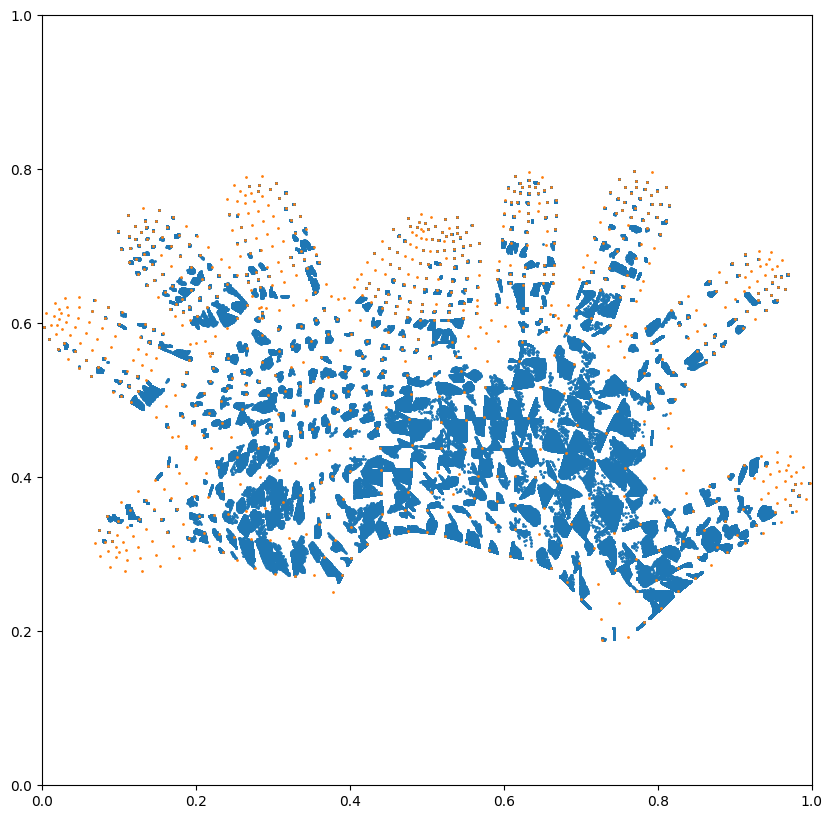

In [68]:
import warping.get_point_mesh_face_distance as get_point_mesh_face_distance
import pytorch3d
import warping.get_closest_point_from_triangle as get_closest_point_from_triangle
import warping.get_closest_point_on_mesh_github as get_closest_point_on_mesh_github
import warping.get_vertex_uv as get_vertex_uv
from pytorch3d.io import load_obj

def test_pytorch3d_closest_pt(mesh, points):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    closest_pts = []
    distances_v2 = []
    for i in range(points.shape[1]):
        dist_v2, closest_point = get_closest_point_from_triangle.TestPointMeshDistance._point_to_tri_distance(
            points[0][i],
            mesh.verts_packed()[mesh.faces_packed()[face_ids[i]]]
        )
        closest_pts.append(closest_point)
        distances_v2.append(dist_v2)
    closest_pts = torch.stack(closest_pts)
    distances_v2 = torch.stack(distances_v2)

    # get index where (distances-distances_v2).abs() is max
    indx_max = (distances-distances_v2).abs().argmax()
    print('max diff', (distances-distances_v2).abs().max())
    print('max diff index', indx_max)
    print('distances', distances[indx_max])
    print('distances_v2', distances_v2[indx_max])

    return distances_v2, closest_pts

def test_github_closest_pt(mesh, points):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    clspt_gh = get_closest_point_on_mesh_github.ProjectMesh2Point(mesh)
    closest_points, dist_v3 = clspt_gh(
        points,
        face_ids.unsqueeze(0),
    )
    return closest_points

def test_pytorch3d_closest_pt_batched(mesh, points, vertices_repaired, faces_repaired):
    distances, face_ids = get_point_mesh_face_distance.point_mesh_face_distance(
        mesh,
        pytorch3d.structures.Pointclouds(points=points)
    )
    distances_v2, closest_points = get_closest_point_from_triangle.TestPointMeshDistance._point_to_tri_distance_batched(
        points[0],
        mesh.verts_packed()[mesh.faces_packed()[face_ids]]
    )
    closest_points_bary = get_closest_point_from_triangle.TestPointMeshDistance._point_to_bary_batched(
        closest_points,
        mesh.verts_packed()[mesh.faces_packed()[face_ids]]
    )
    # assert that each barycentric coordinate is between 0 and 1
    assert (closest_points_bary >= -1e-4).all() and (closest_points_bary <= 1 + 1e-4).all()
    closest_points_bary = closest_points_bary.clamp(0, 1)

    closest_pts_uv = get_vertex_uv.get_point_uv(closest_points_bary, face_ids)

    is_inside = kaolin.ops.mesh.check_sign(vertices_repaired, faces_repaired, closest_points.unsqueeze(0))
    print('is_inside', is_inside.int().sum())
    # multiply distances with -1 if point is inside
    distances_v2 = distances_v2 * (is_inside.int() * -2 + 1)

    return distances_v2, closest_points, closest_pts_uv


mesh_not_repaired = pytorch3d.structures.Meshes(
    verts=verts_zero_pose,
    faces=faces_zero_pose,
)

points_to_query = pytorch3d.ops.sample_points_from_meshes(mesh_not_repaired, 1000000) * 2
print(points_to_query.shape)
# points_to_query = torch.rand(1, 5000, 3) * 0.5 - 0.25
print(points_to_query.shape)

mesh_not_repaired = mesh_not_repaired.to(device)
points_to_query = points_to_query.to(device)

distances_batched, pts_batched, uvs_batched = test_pytorch3d_closest_pt_batched(
    mesh_not_repaired,
    points_to_query,
    torch.tensor(vertices_repaired).unsqueeze(0).to(device),
    torch.tensor(faces_repaired).to(device),
)

%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(x=uvs_batched[:, 0].cpu().numpy(), y=uvs_batched[:, 1].cpu().numpy(), s=1)

# set axes equal
ax.set_aspect('equal', adjustable='box')
# set axes limits 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

print('batched pts', pts_batched)
print('batched distances', distances_batched.mean(), distances_batched.min(), distances_batched.max())
print('points_to_query', points_to_query)


verts_from_obj, faces_from_obj, aux = load_obj(
    '/itet-stor/azhuavlev/net_scratch/Projects/Data/models/mano/uv_maps/MANO_UV_left.obj')

print('aux.verts_uvs', aux.verts_uvs)

ax.scatter(x=aux.verts_uvs[:, 0].cpu().numpy(), y=aux.verts_uvs[:, 1].cpu().numpy(), s=1)

assert (faces_from_obj.verts_idx == faces_zero_pose).all()

# ax = fig.add_subplot(122, projection='3d')
#
# ax.plot_trisurf(mesh_repaired_trimesh.vertices[:, 0], mesh_repaired_trimesh.vertices[:, 1], mesh_repaired_trimesh.vertices[:, 2], triangles=mesh_repaired_trimesh.faces, alpha=0.5)
#
# ax.scatter(xs=points_to_query[0, :, 0].cpu().numpy(), ys=points_to_query[0, :, 1].cpu().numpy(), zs=points_to_query[0, :, 2].cpu().numpy(), s=1, c='r')
#
# ax.axis('equal')
# print('faces_from_obj', faces_from_obj.verts_idx)
# print('faces_zero_pose', faces_zero_pose)

# fixme: I am not entirely sure if everything is correct. Run experiments to check

In [59]:
import kaolin
import warping.kaolin_test as kaolin_test
kaolin_test.test_kaolin()

checking kaolin...
check_sign tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False,  True, False, False,
         False, False, False,  True, False,  True, False]], device='cuda:0')
point_to_mesh_distance tensor([[ 0.2500, 41.0000]], device='cuda:0') tensor([[0, 0]], device='cuda:0') tensor([[5, 5]], device='cuda:0', dtype=torch.int32)


In [ ]:
pts_x = torch.linspace(-0.15, 0.15, 100)

points = torch.stack(torch.meshgrid(pts_x, pts_x, pts_x), dim=-1).reshape(1, -1, 3)
points.shape

In [ ]:
import kaolin

is_inside = kaolin.ops.mesh.check_sign(vertices_repaired.to('cuda'), faces_repaired.to('cuda'), points.to('cuda'))
is_inside

In [ ]:
# plot 1000 random points on 3d plot, color red if inside, blue if outside
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
# select only points inside mesh
points_inside = points[is_inside.cpu().int() == 1].cpu()
indices = np.random.choice(points_inside.shape[0], 1000, replace=False)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_inside[indices, 0], points_inside[indices, 1], points_inside[indices, 2], c='r', marker='o')
ax.axis('equal')

In [ ]:
is_inside.int().sum()

In [ ]:
torch.cuda.is_available()

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# verts = torch.tensor([[[0., 0., 0.],
#                        [1., 0.5, 1.],
#                        [0.5, 1., 1.],
#                        [1., 1., 0.5]]], device=device)
# faces = torch.tensor([[0, 3, 1],
#                       [0, 1, 2],
#                       [0, 2, 3],
#                       [3, 2, 1]], device=device)
# axis = torch.linspace(0.1, 0.9, 3, device=device)
# p_x, p_y, p_z = torch.meshgrid(axis + 0.01, axis + 0.02, axis + 0.03)
# points = torch.cat((p_x.unsqueeze(-1), p_y.unsqueeze(-1), p_z.unsqueeze(-1)), dim=3)
# points = points.view(1, -1, 3)
# print('check_sign', kaolin.ops.mesh.check_sign(verts, faces, points))

In [ ]:
#